# Smoothing of additive state functionals via variational approximations

## Codebase
*You can fold all this part but you need to run it if you want to run experiments below*

### Dependencies

*Uncommented an run this cell if you want to relaunch all cells in Colab*

In [ ]:
#!pip install -r requirements.txt

### Imports

In [1]:
from functools import partial
from copy import deepcopy

from IPython.display import display, Markdown, Latex

from jax import lax, numpy as jnp, random, config, jit, vmap, value_and_grad
from jax.scipy.stats.multivariate_normal import logpdf as jax_gaussian_logpdf
import optax

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


from backward_ica.elbo import linear_gaussian_elbo
from backward_ica.hmm import LinearGaussianHMM
from backward_ica.kalman import filter as kalman_filter, smooth as kalman_smooth
from backward_ica.misc import parameters_from_raw_parameters


config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

### Utility functions

In [2]:
def parameters_from_raw_parameters(raw_model):

    model = deepcopy(raw_model)
    
    model['prior']['cov'] = jnp.diag(raw_model['prior']['cov'] ** 2) 
    model['transition']['weight'] = jnp.diag(model['transition']['weight'])

    model['transition']['cov'] = jnp.diag(raw_model['transition']['cov'] ** 2)
    model['emission']['cov'] = jnp.diag(raw_model['emission']['cov'] ** 2)
                    
    return model

### Kalman 

In [3]:
def predict(current_state_mean, current_state_cov, transition):
    predictive_mean = transition['weight'] @ current_state_mean + transition['bias']
    predictive_cov = transition['weight'] @ current_state_cov @ transition['weight'].T + transition['cov']
    return predictive_mean, predictive_cov

def update(predictive_mean, predictive_cov, observation, emission):
    predicted_observation_mean = emission['weight'] @ predictive_mean + emission['bias']
    predicted_observation_cov = emission['weight'] @ predictive_cov @ emission['weight'].T + emission['cov']
    kalman_gain = predictive_cov  @ emission['weight'].T @ jnp.linalg.inv(predicted_observation_cov)

    corrected_state_mean = predictive_mean + kalman_gain @ (observation - predicted_observation_mean)
    corrected_state_cov = predictive_cov - kalman_gain @ emission['weight'] @ predictive_cov

    return corrected_state_mean, corrected_state_cov

def filter_step(current_state_mean, current_state_cov, observation, transition, emission):
    predicted_mean, predicted_cov = predict(current_state_mean, current_state_cov, transition)
    filtered_mean, filtered_cov = update(predicted_mean, predicted_cov, observation, emission)
    return predicted_mean, predicted_cov, filtered_mean, filtered_cov

def init(observation, prior, emission):
    init_filtering_mean, init_filtering_cov = update(prior['mean'], prior['cov'], observation, emission)
    return prior['mean'], prior['cov'], init_filtering_mean, init_filtering_cov

def log_likelihood_term(predictive_mean, predictive_cov, observation, emission):
    return jax_gaussian_logpdf(x=observation, 
                        mean=emission['weight'] @ predictive_mean + emission['bias'], 
                        cov=emission['weight'] @ predictive_cov @ emission['weight'].T + emission['cov'])


def filter(observations, model):
    init_predictive_mean, init_predictive_cov, init_filtering_mean, init_filtering_cov = init(observations[0], model['prior'], model['emission'])
    loglikelihood = log_likelihood_term(init_predictive_mean, init_predictive_cov, observations[0], model['emission'])

    def _step(carry, x):
        loglikelihood, filtering_mean, filtering_cov, transition, emission  = carry
        predictive_mean, predictive_cov, filtering_mean, filtering_cov = filter_step(current_state_mean=filtering_mean,
                                                                                    current_state_cov=filtering_cov,
                                                                                    observation=x,
                                                                                    transition=transition,
                                                                                    emission=emission)

        loglikelihood += log_likelihood_term(predictive_mean, predictive_cov, x, emission)

        return (loglikelihood, filtering_mean, filtering_cov, transition, emission), (predictive_mean, predictive_cov, filtering_mean, filtering_cov)

    (loglikelihood, *_), (predictive_means, predictive_covs, filtering_means, filtering_covs) = lax.scan(f=_step, 
                                init=(loglikelihood, init_filtering_mean, init_filtering_cov, model['transition'], model['emission']), 
                                xs=observations[1:])

    predictive_means = jnp.concatenate((init_predictive_mean[None,:], predictive_means))
    predictive_covs = jnp.concatenate((init_predictive_cov[None,:], predictive_covs))
    filtering_means =  jnp.concatenate((init_filtering_mean[None,:], filtering_means))
    filtering_covs =  jnp.concatenate((init_filtering_cov[None,:], filtering_covs))

    return predictive_means, predictive_covs, filtering_means, filtering_covs, loglikelihood


def smooth_step(carry, x):
    next_smoothing_mean, next_smoothing_cov, transition_matrix = carry 
    filtering_mean, filtering_cov, next_predictive_mean, next_predictive_cov = x  
    
    C = filtering_cov @ transition_matrix @ jnp.linalg.inv(next_predictive_cov)
    smoothing_mean = filtering_mean + C @ (next_smoothing_mean - next_predictive_mean)
    smoothing_cov = filtering_cov + C @ (next_smoothing_cov - next_predictive_cov) @ C.T

    return (smoothing_mean, smoothing_cov, transition_matrix), (smoothing_mean, smoothing_cov)


def smooth(observations, model):

    predictive_means, predictive_covs, filtering_means, filtering_covs = filter(observations, model)[:-1]

    last_smoothing_mean, last_smoothing_cov = filtering_means[-1], filtering_covs[-1]

    _, (smoothing_means, smoothing_covs) = lax.scan(f=smooth_step,
                                            init=(last_smoothing_mean, last_smoothing_cov, model['transition']['weight']),
                                            xs=(filtering_means[:-1], 
                                                filtering_covs[:-1],
                                                predictive_means[1:],
                                                predictive_covs[1:]),
                                            reverse=True)

    smoothing_means = jnp.concatenate((smoothing_means, last_smoothing_mean[None,:]))
    smoothing_covs = jnp.concatenate((smoothing_covs, last_smoothing_cov[None,:]))

    return smoothing_means, smoothing_covs

### HMMs 

In [4]:
class LinearGaussianHMM:

    def get_random_model(key, state_dim=2, obs_dim=2):
        default_state_cov = 1e-2*jnp.ones(state_dim)
        default_emission_cov = 1e-2*jnp.ones(obs_dim)

        key, *subkeys = random.split(key, 2)
        prior_mean = random.uniform(subkeys[0], shape=(state_dim,))
        prior_cov = default_state_cov

        key, *subkeys = random.split(key, 3)
        transition_weight = random.uniform(subkeys[0], shape=(state_dim,))
        transition_bias = random.uniform(subkeys[1], shape=(state_dim,))
        transition_cov = default_state_cov

        key, *subkeys = random.split(key, 3)
        emission_weight = random.uniform(subkeys[0], shape=(obs_dim,state_dim))
        emission_bias = random.uniform(subkeys[1], shape=(obs_dim,))
        emission_cov = default_emission_cov

        return {'prior':{'mean':prior_mean, 'cov':prior_cov}, 
                'transition': {'weight':transition_weight, 'bias': transition_bias,'cov':transition_cov},
                'emission': {'weight':emission_weight, 'bias': emission_bias,'cov':emission_cov}}

    def sample_single_step_joint(carry, x):
        key, previous_state, transition, emission = carry
        key, *subkeys = random.split(key, 3)

        new_state = random.multivariate_normal(key=subkeys[0], 
                                        mean=transition['weight'] @ previous_state + transition['bias'],
                                        cov=transition['cov'])

        new_obs = random.multivariate_normal(key=subkeys[1], 
                                    mean=emission['weight'] @ new_state + emission['bias'],
                                    cov=emission['cov'])

        return (key, new_state, transition, emission), (new_state, new_obs)

    def sample_joint_sequence(key, model, length):

        key, *subkeys = random.split(key, 3)
        init_state = random.multivariate_normal(key=subkeys[0], 
                                        mean=model['prior']['mean'],
                                        cov=model['prior']['cov'])

        init_obs = random.multivariate_normal(key=subkeys[1], 
                                        mean=model['emission']['weight'] @ init_state + model['emission']['bias'], 
                                        cov=model['emission']['cov'])

        (key, *_), (state_samples, obs_samples) = lax.scan(f=LinearGaussianHMM.sample_single_step_joint, 
                                                init=(key, init_state, model['transition'], model['emission']), 
                                                length=length-1,
                                                xs=None)
        
        state_samples = jnp.concatenate((init_state[None,:], state_samples))
        obs_samples = jnp.concatenate((init_obs[None,:], obs_samples))

        return state_samples, obs_samples

### ELBOs

In [5]:
kalman_filter_step = filter_step
kalman_init = init 

config.update("jax_enable_x64", True)


def _create_quad_form(A, b, Omega):
    return {'A':A, 'b':b, 'Omega':Omega}

def _create_filtering(mean, cov):
    return {'mean':mean, 'cov':cov}

def _create_backward(A, a, cov):
    return {'A':A, 'a':a, 'cov':cov}

def _update_quad_forms_at_index(quad_forms, quad_form, index):
    quad_forms['A'] = quad_forms['A'].at[index].set(quad_form['A'])
    quad_forms['b'] = quad_forms['b'].at[index].set(quad_form['b'])
    quad_forms['Omega'] = quad_forms['Omega'].at[index].set(quad_form['Omega'])
    return quad_forms

def _constant_terms_from_log_gaussian(dim, det_cov):
    return -0.5*(dim * jnp.log(2*jnp.pi) + jnp.log(det_cov))

def _eval_quad_form(quad_form, x):
    common_term = quad_form['A'] @ x + quad_form['b']
    return common_term.T @ quad_form['Omega'] @ common_term

def _expect_obs_term_under_backward(obs_term, q_backward):
    return _expect_quad_form_under_backward(obs_term, q_backward)

def _expect_obs_term_under_filtering(obs_term, q_filtering):
    return _expect_quad_form_under_filtering(obs_term, q_filtering)

def _get_obs_term(observation, p_emission):
    
    return _create_quad_form(A=p_emission['weight'],
                            b=p_emission['bias'] - observation,
                            Omega=- 0.5*p_emission['prec'])

def _init_filtering(observation, q_prior, q_emission):
    return _create_filtering(*kalman_init(observation, q_prior, q_emission)[2:])

def _update_filtering(observation, q_filtering, q_transition, q_emission):
    return _create_filtering(*kalman_filter_step(q_filtering['mean'], q_filtering['cov'], observation, q_transition, q_emission)[2:])

def _update_backward(q_filtering, q_transition):

    filtering_prec = jnp.linalg.inv(q_filtering['cov'])

    backward_prec = q_transition['weight'].T @ q_transition['prec'] @ q_transition['weight'] + filtering_prec

    cov = jnp.linalg.inv(backward_prec)

    common_term = q_transition['weight'].T @ q_transition['prec'] 
    A = cov @ common_term
    a = cov @ (filtering_prec @ q_filtering['mean'] - common_term @  q_transition['bias'])

    return _create_backward(A=A,a=a,cov=cov)

def _integrate_previous_terms(integrate_up_to, quad_forms, nonlinear_term, q_backward):

    quad_forms_transition, quad_forms_emission = quad_forms

    masks = jnp.arange(start=0, stop=quad_forms_transition['A'].shape[0]) <= integrate_up_to
    _expect_quad_forms_under_backward_masked = vmap(_expect_quad_form_under_backward_masked, in_axes=(0,0,None))
    
    constants0, quad_forms_transition = _expect_quad_forms_under_backward_masked(masks, quad_forms_transition, q_backward)

    masks = masks.at[integrate_up_to].set(False)
    constants1, quad_forms_emission = _expect_quad_forms_under_backward_masked(masks, quad_forms_emission, q_backward)

    constants2, quad_form = _expect_obs_term_under_backward(nonlinear_term, q_backward)

    quad_forms_emission = _update_quad_forms_at_index(quad_forms_emission, 
                                                    quad_form, 
                                                    index=integrate_up_to)

    return jnp.sum(constants0) + jnp.sum(constants1) + constants2, quad_forms_transition, quad_forms_emission


def _init_V(observation, p):

    constants_V = _constant_terms_from_log_gaussian(p['transition']['cov'].shape[0], jnp.linalg.det(p['prior']['cov'])) + \
                  _constant_terms_from_log_gaussian(p['emission']['cov'].shape[0], p['emission']['det_cov'])
    
    init_transition_term = {'A':jnp.eye(p['transition']['cov'].shape[0]), 'b':-p['prior']['mean'], 'Omega':-0.5 * jnp.linalg.inv(p['prior']['cov'])}
    nonlinear_term = _get_obs_term(observation, p['emission'])

    return constants_V, init_transition_term, nonlinear_term 

def _expect_transition_quad_form_under_backward(q_backward, p_transition):
    # expectation of the quadratic form that appears in the log of the state transition density

    A=p_transition['weight'] @ q_backward['A'] - jnp.eye(p_transition['cov'].shape[0])
    b=p_transition['weight'] @ q_backward['a'] + p_transition['bias']
    Omega = -0.5*p_transition['prec']

    return {'A':A, 'b':b, 'Omega':Omega} 

def _no_integration(quad_form, q_backward):
    return 0.0, quad_form

def _expect_quad_form_under_backward(quad_form, q_backward):
    Sigma = quad_form['A'] @ q_backward['cov'] @ quad_form['A'].T
    constant = jnp.trace(quad_form['Omega'] @ Sigma)
    A = quad_form['A'] @ q_backward['A']
    b = quad_form['A'] @ q_backward['a'] + quad_form['b']
    Omega = quad_form['Omega']
    return constant, {'A':A, 'b':b, 'Omega':Omega}

def _expect_quad_form_under_backward_masked(mask, quad_form, q_backward):
    # if mask: 
    #     return _expect_quad_form_under_backward(quad_form, q_backward)

    # return _no_integration(quad_form, q_backward)
    return lax.cond(mask, _expect_quad_form_under_backward, _no_integration, quad_form, q_backward)

def _update_V(observation, integrate_up_to, quad_forms, nonlinear_term, q_backward, p):

    constants, quad_forms_transition, quad_forms_emission =  _integrate_previous_terms(integrate_up_to, quad_forms, nonlinear_term, q_backward)

    dim_z, dim_x = p['transition']['cov'].shape[0], p['emission']['cov'].shape[0]
    constants +=  _constant_terms_from_log_gaussian(dim_x, p['emission']['det_cov']) \
                +   _constant_terms_from_log_gaussian(dim_z, p['transition']['det_cov']) \
                + - _constant_terms_from_log_gaussian(dim_z, jnp.linalg.det(q_backward['cov'])) \
                +  0.5 * dim_z \
                + - 0.5 * jnp.trace(p['transition']['prec'] @ p['transition']['weight'] @ q_backward['cov'] @ p['transition']['weight'].T)

    quad_form = _expect_transition_quad_form_under_backward(q_backward, p['transition'])


    quad_forms_transition = _update_quad_forms_at_index(quad_forms_transition, 
                                                    quad_form, 
                                                    index=integrate_up_to+1)
    
    nonlinear_term = _get_obs_term(observation, p['emission'])

    return constants, [quad_forms_transition, quad_forms_emission], nonlinear_term

def _expect_quad_form_under_filtering(quad_form, q_filtering):
    return jnp.trace(quad_form['Omega'] @ quad_form['A'] @ q_filtering['cov'] @ quad_form['A'].T) + _eval_quad_form(quad_form, q_filtering['mean'])

def _expect_V_under_filtering(constants_V, quad_forms, nonlinear_term, q_filtering):
    result = constants_V

    quad_forms_transition, quad_forms_emission = quad_forms
    quad_forms_emission['A'] = quad_forms_emission['A'][:-1]
    quad_forms_emission['b'] = quad_forms_emission['b'][:-1]
    quad_forms_emission['Omega'] = quad_forms_emission['Omega'][:-1]

    expect_quad_forms_under_filtering = vmap(_expect_quad_form_under_filtering, in_axes=(0, None))

    result += jnp.sum(expect_quad_forms_under_filtering(quad_forms_transition, q_filtering)) \
            + jnp.sum(expect_quad_forms_under_filtering(quad_forms_emission, q_filtering)) \
            + _expect_obs_term_under_filtering(nonlinear_term, q_filtering)

    result += 0.5*q_filtering['mean'].shape[0]

    return result

def init(observations, p, q):

    constants_V, init_transition_term, nonlinear_term = _init_V(observations[0], p)
    q_filtering = _init_filtering(observations[0], q['prior'], q['emission'])
    dim_z = p['transition']['cov'].shape[0]

    num_terms = len(observations)
    As = jnp.empty(shape=(num_terms, dim_z, dim_z))
    bs = jnp.empty(shape=(num_terms, dim_z))
    Omegas = jnp.empty(shape=(num_terms, dim_z, dim_z))

    As = As.at[0].set(init_transition_term['A'])
    bs  = bs.at[0].set(init_transition_term['b'])
    Omegas = Omegas.at[0].set(init_transition_term['Omega'])

    quad_forms_transition = _create_quad_form(A=As, b=bs, Omega=Omegas)

    dim_x = p['emission']['cov'].shape[0]

    quad_forms_emission = _create_quad_form(A=jnp.empty(shape=(num_terms, dim_x, dim_z)),
                                            b=jnp.empty(shape=(num_terms, dim_x)),
                                            Omega=jnp.empty(shape=(num_terms, dim_x, dim_x)))
            
    quad_forms = [quad_forms_transition, quad_forms_emission]
    return constants_V, quad_forms, nonlinear_term, q_filtering

def _update(observation, integrate_up_to, quad_forms, nonlinear_term, q_filtering, p, q):
    q_backward = _update_backward(q_filtering, q['transition'])
    constants, quad_forms, nonlinear_term = _update_V(observation, 
                                                    integrate_up_to,
                                                    quad_forms, 
                                                    nonlinear_term, 
                                                    q_backward, 
                                                    p)

    q_filtering = _update_filtering(observation, q_filtering, q['transition'], q['emission'])

    return constants, quad_forms, nonlinear_term, q_filtering

def prepare_parameters(model):

    model = parameters_from_raw_parameters(model)

    model['transition']['prec'] =  jnp.linalg.inv(model['transition']['cov'])
    model['transition']['det_cov'] = jnp.linalg.det(model['transition']['cov'])

    model['emission']['prec'] =  jnp.linalg.inv(model['emission']['cov'])
    model['emission']['det_cov'] = jnp.linalg.det(model['emission']['cov'])


    return model

def linear_gaussian_elbo(p_raw, q_raw, observations):

    p = prepare_parameters(p_raw)
    q = prepare_parameters(q_raw)
    
    constants_V, quad_forms, nonlinear_term, q_filtering = init(observations, p, q)

    observations = observations[1:]

    integrate_up_to_array = jnp.arange(start=0, stop=len(observations))

    
    # for observation, integrate_up_to in zip(observations, integrate_up_to_array):
    #     new_constants, quad_forms, nonlinear_term, q_filtering = _update(observation, integrate_up_to, quad_forms, nonlinear_term, q_filtering, p, q)
    #     constants_V += new_constants

    def V_step(carry, x):

        observation, integrate_up_to = x 
        quad_forms, nonlinear_term, q_filtering, p, q = carry 

        new_constants, quad_forms, nonlinear_term, q_filtering = _update(observation, 
                                                                    integrate_up_to,
                                                                    quad_forms, 
                                                                    nonlinear_term, 
                                                                    q_filtering, 
                                                                    p, 
                                                                    q)

        return (quad_forms, nonlinear_term, q_filtering, p, q), new_constants

    (quad_forms, nonlinear_term, q_filtering, p, q), constants = lax.scan(f=V_step, 
                                init=(quad_forms, nonlinear_term, q_filtering, p, q),
                                xs=(observations, integrate_up_to_array))

    constants_V += jnp.sum(constants) 
    constants_V += -_constant_terms_from_log_gaussian(p['transition']['cov'].shape[0], jnp.linalg.det(q_filtering['cov']))

    return _expect_V_under_filtering(constants_V, quad_forms, nonlinear_term, q_filtering)

---
## Introduction

This notebook is comprised of a series of experiments that attempt to recover expectations $\mathbb{E}[h(z_{1:t})|x_{1:t}]$ via variational approximations, when the process $(z_t, x_t)_{t \ge 1}$ is an HMM. The main metric $\ell$ all along is the MSE against the true states when $h$ is a plain sum, ie

$$\ell = \sum_{t=1}^T  \left(z_t^* - \mathbb{E}_{q(z_t|x_{1:T})}[z_t] \right)^2$$

where $q(z_t|x_{1:T}) = q_T(z_t)$ is the marginal smoothing distribution at $t$.

In all the following, we assume that the variational smoothing distribution factorizes, for any $1 \leq t \leq T$, as $$q_\phi(z_{1:t}|x_{1:t}) = q_\phi(z_t|x_{1:t}) \prod_{s=1}^{t-1} q_\phi(z_s|z_{s+1},x_{1:s})$$ where 
- $q_\phi(z_t|x_{1:t}) \sim \mathcal{N}(\mu_{1:t}, \Sigma_{1:t})$ is the *variational filtering distribution*,
- $q_\phi(z_s|z_{s+1},x_{1:s}) \sim \mathcal{N}(\overleftarrow{\mu}_{1:t}(z_{s+1}), \overleftarrow{\Sigma}_{1:t})$ is the *variational backward distribution*.

In the following, we make several assumptions on both $p_\theta$ and $q_\phi$.

---
## 1. $p_\theta$ is a linear Gaussian HMM

First we assume that observation sequences $x_{1:T}$ arise from $p_\theta(z_{1:T},x_{1:T})$ defined as
$$z_t = A_\theta z_{t-1} + a_\theta + \eta_\theta$$ 
$$x_t = B_\theta z_t + b_\theta + \epsilon_\theta$$

where $\eta_\theta \sim \mathcal{N}(0,Q_\theta)$ and $\epsilon_\theta \sim \mathcal{N}(0,R_\theta)$

### 1. a. $q_\phi$ is a linear Gaussian HMM

We start by recovering $p_\theta$ when $q_\phi$ is in the family of the true $p_\theta$. We can do this by prescribing the model for $q_\phi$ in forward time with a similar HMM structure as $p_\theta$ (but random initial parameters). In this case exceptionally, the parameters of the filtering distributions are linked in closed-form to the forward model via the Kalman filtering recursions. Furthermore, the mean of the variational backward is a linear form in $z_{t+1}$, ie. $$\overleftarrow{\mu}_{1:t}(z_{t+1}) = \overleftarrow{A}_{1:t} z_{t+1} + \overleftarrow{a}_{1:t}$$

where $\overleftarrow{A}_{1:t}$ and $\overleftarrow{a}_{1:t}$ are given in closed-form via the Kalman smoothing recursions.

For this experiment, not only should the expectations be correctly recovered, but parameters in $\phi$ and $\theta$ may be identifiable in some cases (depending on the conditioning of $p_\theta$). We also know that in this case the best estimate of $z_{1:t}^*$ for any sequence is obtained via the Kalman smoothing recursions applied with the true parameters $\theta$, so we have an optimal estimator to compare to. 


#### Checking that $\mathcal{L}(\theta, \theta) = \log p_\theta$ 
*Remark: here $\log p$ is computed with Kalman*

In [6]:
state_dim, obs_dim = 2, 3
num_sequences = 30
length = 16
display(Markdown(f'Number of observations per sequence: {length}'))
display(Markdown(f'Number of sequences: {num_sequences}'))

key, *subkeys = random.split(key, 3)

p_raw = LinearGaussianHMM.get_random_model(key=subkeys[0], state_dim=state_dim, obs_dim=obs_dim)

p = parameters_from_raw_parameters(p_raw)

linear_gaussian_sampler = vmap(LinearGaussianHMM.sample_joint_sequence, in_axes=(0, None, None))
key, *subkeys = random.split(key, num_sequences+1)
state_sequences, obs_sequences = linear_gaussian_sampler(jnp.array(subkeys), p, length)


filter_obs_sequences = vmap(kalman_filter, in_axes=(0, None))
elbo_sequences = jit(vmap(linear_gaussian_elbo, in_axes=(None, None, 0)))

average_evidence_across_sequences = jnp.mean(filter_obs_sequences(obs_sequences, p)[-1])
display(Latex(f'Average $\log p_\\theta(x)$ across sequences $x$: {average_evidence_across_sequences:.2f}'))
average_elbo_across_sequences_with_true_model = jnp.mean(elbo_sequences(p_raw, p_raw, obs_sequences))
display(Latex('Average $|\mathcal{L}(\\theta,\\theta)- \log p_\\theta(x)|$ across sequences: ' + f'{jnp.abs(average_elbo_across_sequences_with_true_model-average_evidence_across_sequences)}'))

Number of observations per sequence: 16

Number of sequences: 30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Optimizing $\phi$ when $\theta$ is fixed

In [7]:
optimizer = optax.adam(learning_rate=-1e-3)

@jit
def step(p_raw, q_raw, opt_state, batch):
    loss_value, grads = value_and_grad(linear_gaussian_elbo, argnums=1)(p_raw, q_raw, batch)
    updates, opt_state = optimizer.update(grads, opt_state, q_raw)
    q_raw = optax.apply_updates(q_raw, updates)
    return p_raw, q_raw, opt_state, -loss_value

q_raw = LinearGaussianHMM.get_random_model(key=subkeys[1], state_dim=state_dim, obs_dim=obs_dim)
average_elbo_across_sequences_with_init_q = jnp.mean(elbo_sequences(p_raw, q_raw, obs_sequences))
display(Latex('Average $|\mathcal{L}(\\theta,\\phi)- \log p_\\theta(x)|$ across sequences:' +  f'{jnp.abs(average_evidence_across_sequences-average_elbo_across_sequences_with_init_q):.2f}'))

<IPython.core.display.Latex object>

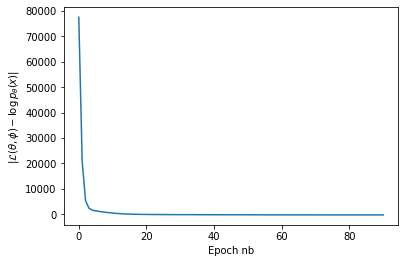

In [8]:
def fit(p_raw, q_raw, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(q_raw)

    eps = jnp.inf
    old_mean_epoch_elbo = -average_elbo_across_sequences_with_init_q
    epoch_nb = 0
    mean_elbos = [old_mean_epoch_elbo - average_evidence_across_sequences]
    while eps > 1e-2:
        epoch_elbo = 0.0
        for batch in obs_sequences: 
            p_raw, q_raw, opt_state, elbo_value = step(p_raw, q_raw, opt_state, batch)
            epoch_elbo += elbo_value
        mean_epoch_elbo = epoch_elbo/len(obs_sequences)
        eps = jnp.abs(mean_epoch_elbo - old_mean_epoch_elbo)
        epoch_nb+=1
        mean_elbos.append(mean_epoch_elbo - average_evidence_across_sequences)
        old_mean_epoch_elbo = mean_epoch_elbo
    return q_raw, mean_elbos


fitted_q_raw, mean_elbos = fit(p_raw, q_raw, optimizer)

plt.plot(mean_elbos)
plt.xlabel('Epoch nb'), 
plt.ylabel('$|\mathcal{L}(\\theta,\\phi)- \log p_\\theta(x)|$')
fitted_q = parameters_from_raw_parameters(fitted_q_raw)

#### Computing expectations 


In [9]:
def squared_error_expectation_against_true_states(states, observations, approximate_linear_gaussian_model, additive_functional):
    smoothed_states, _ = kalman_smooth(observations, approximate_linear_gaussian_model)
    return jnp.sqrt((additive_functional(smoothed_states) - additive_functional(states)) ** 2)

additive_functional = partial(jnp.sum, axis=0)
mse_in_expectations = vmap(squared_error_expectation_against_true_states, in_axes=(0,0, None, None))
print('MSE(E_q(h(z)), z_true):', jnp.mean(mse_in_expectations(state_sequences, obs_sequences, fitted_q, additive_functional), axis=0))
print('MSE(E_p(h(z)), z_true):', jnp.mean(mse_in_expectations(state_sequences, obs_sequences, p, additive_functional), axis=0))

MSE(E_q(h(z)), z_true): [0.0873562  0.08952309]
MSE(E_p(h(z)), z_true): [0.02279203 0.0420618 ]


### 1. b. $q_\phi$ is prescribed only through its filtering and backward distributions whose parameters are estimated by neural networks

We can keep the assumption that $\overleftarrow{\mu}_{1:t}(z_{t+1}) = \overleftarrow{A}_{1:t} z_{t+1} + \overleftarrow{a}_{1:t}$ to allow the recursion on the ELBO, but predict $\mu_{1:t}, \Sigma_{1:t},  \overleftarrow{A}_{1:t}$ and $\overleftarrow{a}_{1:t}$ with neural networks (e.g. recurrent networks updated sequentially with new observations $x_t$). 

*TODO*

---
## 2. $p_\theta$ is an HMM with a linear transition but a nonlinear emission

We now assume that $p_\theta$ has a nonlinear emission distribution, ie. $x_t  = f_\theta(z_t) + \epsilon$.

### 2. a. $q_\phi$ is a linear Gaussian HMM 
We keep a linear gaussian distribution for $q_\phi$, but we add a mapping to compute the expectation of the emission term from $p_\theta$. We need to approximate the following quantity:

$$\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}\left[(x_t - f_\theta(z_t))^T R^{{\theta}^{-1}}(x_t - f_\theta(z_t))\right]$$

And similarly for the last expectation under the filtering distribution: 

$$\mathbb{E}_{q(z_T|x_{1:T})}\left[(x_T - f_\theta(z_T))^T R^{{\theta}^{-1}}(x_T - f_\theta(z_T))\right]$$

#### 2. a. i. Sketch of a method using the expected value of quadratic forms 


If we know the expectation $\mu$ and variance $\Sigma$ of a random variable $v$ with distribution $p_v$ (which need not be Gaussian), the following holds:

$$\mathbb{E}_{v \sim p_v}\left[(x - v)^T \Omega (x - v)\right] = tr(\Omega \Sigma) + (\mu - x)^T \Omega (\mu - x)$$

Suppose we a have neural network which approximates the mean and variance of $v \sim f_\theta(z)$ when $z \sim p_z$, given parameters of $p_z$. Denote $\tilde{\mu}_v$ and $\tilde{\Sigma}_v$ these estimated means and variances. For the filtering case, we feed the network with filtering mean and covariance at $T$ to obtain an estimate of $\tilde{\mu}_v$ and $\tilde{\Sigma}_v$, then:

$$\mathbb{E}_{q(z_T|x_{1:T})}\left[(x_T - f_\theta(z_T))^T R^{{\theta}^{-1}}(x_T - f_\theta(z_T))\right] = tr(\Omega \tilde{\Sigma}_v) + (\tilde{\mu}_v - x)^T R^{{\theta}^{-1}} (\tilde{\mu}_v - x)$$

For the backwards case this is not as simple, because: $\overleftarrow{\mu}_{1:t}$ is a function of $z_{t+1}$, therefore $\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}[f_\theta(z_t)]$ and $\mathbb{V}_{q(z_t|z_{t+1}, x_{1:t})}[f_\theta(z_t)]$ are also functions of $z_{t+1}$. 

We can still attempt to use one network for both the fitlering and the backwards via the following scheme: 

- Build a neural network $g_\alpha(A, a, \Sigma)$ which outputs $\tilde{A}_v, \tilde{a}_v$ and $\tilde{\Sigma}_v$
- For the backwards case, use $A = \overleftarrow{A}_{1:t}, a = \overleftarrow{a}_{1:t}$ and $\Sigma = \overleftarrow{\Sigma}_{1:t}$, and consider that $\tilde{\mu}_v = \tilde{A}_vz_{t+1} + \tilde{a}_v$. 
- For the filtering case, use $A = 0, a = a_{1:t}$ and $\Sigma = \Sigma_{1:t}$, and consider that $\tilde{\mu}_v = \tilde{a}_v$ (without using the output $\tilde{A}_v$).

Since the variance $\mathbb{V}_{q(z_t|z_{t+1}, x_{1:t})}[f_\theta(z_t)]$ is a function of $z_{t+1}$, the term in $tr(\Omega \tilde{\Sigma}_v)$ breaks the quadratic form and prevents computations in the next steps. This method might still be useful if: 

- We suppose that $\tilde{\Sigma}_v \approx \tilde{\Sigma}_v' z_{t+1} z_{t+1}^T$ therefore reintroducing the quadratic assumption.
- We let go of the online recursion and perform computations online, therefore allowing more flexible estimates outside the quadratic family 

#### 2. a. ii. Using a sampling based approach and a neural network similar to [Johnson et al.](https://arxiv.org/pdf/1603.06277.pdf)

At any time $t$, the predictive distribution $q(z_{t+1}|x_{1:t})$ is easily available via a Kalman predict step. Therefore a sample from the variational backward is easily obtained by sampling:

$$\zeta \sim q(z_{t+1}|x_{1:t})$$ 
then 

$$\xi \sim q(z_t|z_{t+1}=\zeta ,x_{1:t})$$

such that $(x_t - f_\theta(\xi))^T R^{{\theta}^{-1}}(x_t - f_\theta(\xi))$ is the one-sample Monte Carlo estimate of $\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}\left[(x_t - f_\theta(z_t))^T R^{{\theta}^{-1}}(x_t - f_\theta(z_t))\right]$. 

However we are interested in the terms $v, W$ of the quadratic approximation $(z_{t+1} - v)^T W (z_{t+1} - v)$ of this expectation. We could build additional neural networks with parameters $\alpha$ such that $$\mathbb{E}_{q(z_t|z_{t+1}, x_{1:t})}\left[(x_t - f_\theta(z_t))^T R^{{\theta}^{-1}}(x_t - f_\theta(z_t))\right] \approx [z_{t+1} - v_\alpha(\xi)]^T W_\alpha(\xi) [z_{t+1} - v_\alpha(\xi)]$$

This requires fitting $\alpha$ at a fixed $(\theta, \phi)$

#### 2. a. iii. Using [Johnson et al.](https://arxiv.org/pdf/1603.06277.pdf) as is